In [ ]:
import json
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import combinations_with_replacement

from pathlib import Path
import matplotlib.pyplot as plt
import prettypyplot as pplt
pplt.use_style(true_black=True, sf=False)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams.update({"font.size": 9, "figure.dpi": 220, 'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})
figpath = Path()
linewidth = 3.40457 # Two column page in inch
linewidth_double = 7.05826  # One column page in inch

In [5]:
bead_types = []
epsilon_values = None
sigma_values = None
reading_status = None
with open('martini.itp') as file:
	for line in file:
		if line.startswith(';'):
			continue
		if 'atomtypes' in line:
			reading_status = 1
		elif 'nonbond_params' in line:
			print(f'Number of bead types: {len(bead_types)}')
			reading_status = 2
			epsilon_values = np.zeros((len(bead_types), len(bead_types)))
			sigma_values = np.zeros((len(bead_types), len(bead_types)))
		elif reading_status == 1 and len(line) > 5:
			bead_types.append(line.split()[0])
		elif reading_status == 2 and len(line) > 5:
			bead1, bead2, _, sigma, epsilon = line.split()
			i, j = bead_types.index(bead1), bead_types.index(bead2)
			epsilon_values[i, j] = epsilon_values[j, i] = float(epsilon)
			sigma_values[i, j] = sigma_values[j, i] = float(sigma)
epsilon_values = pd.DataFrame(epsilon_values, index=bead_types, columns=bead_types)
sigma_values = pd.DataFrame(sigma_values, index=bead_types, columns=bead_types)

Number of bead types: 844


In [ ]:
with open('mapping.json', 'r') as file:
	mapping_list = json.load(file)
for mapping in mapping_list:

	print(mapping)

{'Q': ['Q5', 'Q4', 'Q3', 'Q2', 'Q1'], 'P': ['P6', 'P5', 'P4', 'P3', 'P2', 'P1'], 'N': ['N6', 'N5', 'N4', 'N3', 'N2', 'N1'], 'C': ['C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'X4', 'X3', 'X2', 'X1']}
{'Q2': ['Q5', 'Q4', 'Q3'], 'Q1': ['Q2', 'Q1'], 'P3': ['P6', 'P5'], 'P2': ['P4', 'P3'], 'P1': ['P2', 'P1'], 'N3': ['N6', 'N5'], 'N2': ['N4', 'N3'], 'N1': ['N2', 'N1'], 'C3': ['C6', 'C5'], 'C2': ['C4', 'C3'], 'C1': ['C2', 'C1'], 'X2': ['X4', 'X3'], 'X1': ['X2', 'X1']}
{'Q5': ['Q5'], 'Q4': ['Q4'], 'Q3': ['Q3'], 'Q2': ['Q2'], 'Q1': ['Q1'], 'P6': ['P6'], 'P5': ['P5'], 'P4': ['P4'], 'P3': ['P3'], 'P2': ['P2'], 'P1': ['P1'], 'N6': ['N6'], 'N5': ['N5'], 'N4': ['N4'], 'N3': ['N3'], 'N2': ['N2'], 'N1': ['N1'], 'C6': ['C6'], 'C5': ['C5'], 'C4': ['C4'], 'C3': ['C3'], 'C2': ['C2'], 'C1': ['C1'], 'X4': ['X4'], 'X3': ['X3'], 'X2': ['X2'], 'X1': ['X1']}


In [29]:
level_names = ['K', 'L']
relevant_bead_types = list(mapping_list[-1].keys()) + [f'S{n}' for n in mapping_list[-1].keys()] + [f'T{n}' for n in mapping_list[-1].keys()]
new_bead_types = {}
new_epsilon_values = {}
epsilon_stds = {0: [], 1: []}
new_sigma_values = {}
for level, mapping in enumerate(mapping_list[:-1]):
	for i, (_, beads) in enumerate(mapping.items()):
		for size in ['', 'S', 'T']:
			name = f'{size}{level_names[level]}{i+1}'
			new_bead_types[name] = beads
			mapped_beads = [f'{size}{bn}' for bn in beads]
			epsilon_list = epsilon_values.loc[mapped_beads].values.mean(axis=0)
			epsilon_mean = epsilon_values.loc[mapped_beads,relevant_bead_types].values.mean(axis=0)
			epsilon_std = epsilon_values.loc[mapped_beads, relevant_bead_types].values.std(axis=0)
			epsilon_stds[level].extend(epsilon_std / epsilon_mean)
			sigma_list = sigma_values.loc[mapped_beads].values.mean(axis=0)
			for j, bead_name in enumerate(bead_types):
				new_epsilon_values[(bead_name, name)] = epsilon_list[j]
				new_sigma_values[(bead_name, name)] = sigma_list[j]
	for i1, (bead_name1, beads1) in enumerate(new_bead_types.items()):
		for i2, (bead_name2, beads2) in enumerate(new_bead_types.items()):
			if i2 >= i1:
				epsilon_list = epsilon_values.loc[beads1, beads2].values.mean()
				sigma_list = sigma_values.loc[beads1, beads2].values.mean()
				new_epsilon_values[(bead_name1, bead_name2)] = epsilon_list
				new_sigma_values[(bead_name1, bead_name2)] = sigma_list

Percentage of epsilon std < 0.1 in low resolution: 66.77%
Percentage of epsilon std < 0.1 in medium resolution: 93.80%


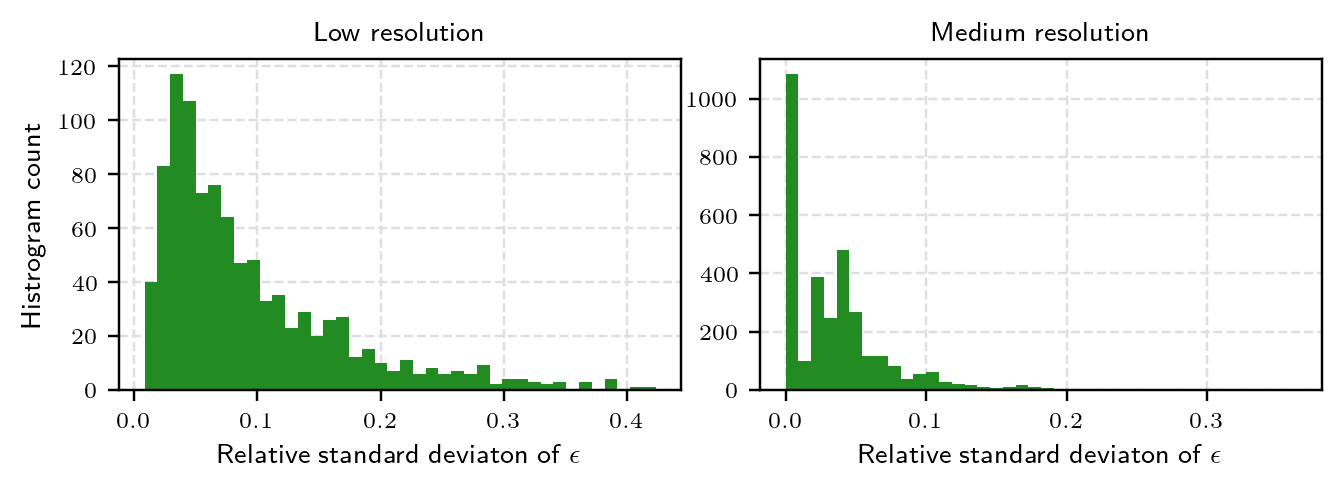

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(linewidth_double, 2.15))
axs[0].hist(epsilon_stds[0], bins=40, color='forestgreen', alpha=1)
bel10lr = (np.array(epsilon_stds[0]) < 0.1).sum() / len(epsilon_stds[0])
print(f'Percentage of epsilon std < 0.1 in low resolution: {bel10lr:.2%}')
bel10mr = (np.array(epsilon_stds[1]) < 0.1).sum() / len(epsilon_stds[1])
print(f'Percentage of epsilon std < 0.1 in medium resolution: {bel10mr:.2%}')
axs[0].set(xlabel='Relative standard deviaton of $\\epsilon$', ylabel='Histrogram count')
axs[0].set_title('Low resolution', fontsize=9)
axs[1].hist(epsilon_stds[1], bins=40, color='forestgreen', alpha=1)
axs[1].set(xlabel='Relative standard deviaton of $\\epsilon$')
axs[1].set_title('Medium resolution', fontsize=9)
fig.subplots_adjust(wspace=0.14)
plt.savefig(figpath / 'mapping-epsilon-std.pdf')
plt.show()

In [ ]:
with open(f'martini_mod.itp', 'w') as output:
	date = datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")
	output.write(f'; Bead-type coarse-graining topology derived from Martini 3\n')
	output.write(f'; Created: {date}\n\n[ defaults ]\n1 2\n\n[ atomtypes ]\n')
	for bead_name in bead_types:
		mass = 36 if bead_name[0] == 'T' else 54 if bead_name[0] == 'S' else 72
		output.write(f'{bead_name:<5s} {mass:.1f} 0.000 A 0.0 0.0\n')
	for bead_name, combined_beads in new_bead_types.items():
		size = 2 if bead_name[0] == 'T' else 1 if bead_name[0] == 'S' else 0
		comment = ' '.join([f'{["","S","T"][size]}{bn}' for bn in combined_beads])
		output.write(f'{bead_name:<5s} {[72, 54, 36][size]:.1f} 0.000 A 0.0 0.0 ; {comment}\n')
	output.write('\n[ nonbond_params ]\n')
	for type1, type2 in combinations_with_replacement(bead_types, r=2):
		output.write(f'{type1:>6s} {type2:>6s}  1 {sigma_values.loc[type1, type2]:.6e}    {epsilon_values.loc[type1, type2]:.6e}\n')
	for type1, type2 in new_epsilon_values.keys():
		output.write(f'{type1:>6s} {type2:>6s}  1 {new_sigma_values[(type1, type2)]:.6e}    {new_epsilon_values[(type1, type2)]:.6e}\n')